# ECE 50024 - Machine Learning - Project

# Conditional Generative Adversarial Networks 

# Suhaib Khan - May 3rd, 2023

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as tvt
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
import pickle
import os
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Get Data  

In [3]:
# Create Transformation and Inverse Transformation for the CIFAR data
transform = tvt.Compose([
    tvt.Resize((64,64)),
    tvt.ToTensor(),
    tvt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

inverse_transform = tvt.Compose([
    tvt.Normalize([0.,0.,0.],[1/0.5,1/0.5,1/0.5]),
    tvt.Normalize([-0.5, -0.5, -0.5],[1.,1.,1.])
])

# Load CIFAR10 Data
train_data = CIFAR10(root='./data',train=True,transform=transform,download=True)

Files already downloaded and verified


### Test data 

In [4]:
len(train_data)

50000

In [5]:
temp_x, temp_label = train_data[5]

In [6]:
temp_x.shape

torch.Size([3, 64, 64])

In [7]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
temp_label

1

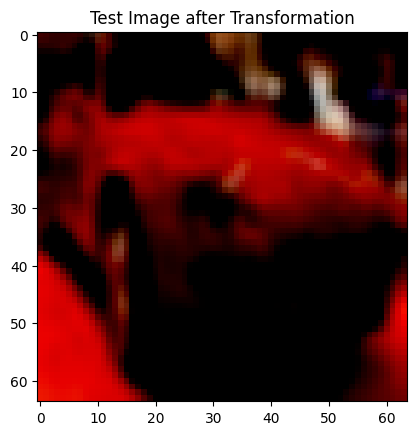

In [10]:
plt.imshow(temp_x.permute(1,2,0))
plt.title('Test Image after Transformation')
plt.show()

# 2. Create Model

In [11]:
class cWGAN_Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize Embedding for 10 labels for the critic
        self.critic_embedding = nn.Embedding(10, 4096)

        self.layers = nn.Sequential(
            
            # First Block - Input Size: 4 x 64 x 64
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
                # No Normalization according to original paper
            nn.LeakyReLU(0.2,inplace=True),
            
            # Second Block - Input Size: 64 x 32 x 32
            self.conv_block(64,128),
            
            # Third Block - Input Size: 128 x 16 x 16
            self.conv_block(128,256),
            
            # Fourth Block - Input Size: 256 x 8 x 8
            self.conv_block(256,512),
            
            # Last Block - Input Size: 512 x 4 x 4
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
            
            # Output = 1 x 1 x 1
        )
        
    def forward(self,x,labels):
        # Embed the 10 labels into 4096 elements and reshape to get a channel
        encoded_labels = self.critic_embedding(labels).view(labels.shape[0],1,64,64)

        # Add 'label' channel to the image
        x = torch.cat([x, encoded_labels],dim=1)

        # Propagate through the layers
        x = self.layers(x)
        
        return x
    
    def conv_block(self, in_ch, out_ch):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=4,stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(out_ch,affine=True),
            nn.LeakyReLU(0.2,inplace=True)
        )
        return block

In [12]:
class cWGAN_Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Create label embeddings for the generator
        self.generator_embedding = nn.Embedding(10, 100)

        self.layers = nn.Sequential(
            
            # First Block - Input Size: 100 length Latent Vector
            nn.ConvTranspose2d(in_channels=200, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            # Second Block - Input Size: 512 x 4 x 4
            self.transpose_conv_block(512,256),
            
            # Third Block - Input Size: 256 x 8 x 8
            self.transpose_conv_block(256,128),
            
            # Fourth Block - Input Size: 128 x 16 x 16
            self.transpose_conv_block(128,64),
            
            # Last Block - Input Size: 64 x 32 x 32
            nn.ConvTranspose2d(in_channels=64, out_channels=3,kernel_size=4,stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # Output = 3 x 64 x 64
        )
    
    def forward(self,x, labels):
        # Get label encodings to 100 elements and unsqueeze to 4 dimensions
        encoded_labels = self.generator_embedding(labels).unsqueeze(2).unsqueeze(3)
        
        # Append label encodings to the input
        x = torch.cat([x, encoded_labels],dim=1)

        # Propagate input through the layers
        x = self.layers(x)
        return x
        
    def transpose_conv_block(self,in_ch, out_ch):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        return block

In [13]:
# https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch
def initialize_weights(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data,0)

In [14]:
# Function to calculate gradient penalty for WGAN
def get_gradient_penalty(critic, real_images, fake_images, labels, lamb, device):
    
    # Initialize batch_size and epsilon
    batch_size = real_images.shape[0]
    epsilon = torch.rand((batch_size,1,1,1)).expand_as(real_images).to(device)
    
    # Get Interpolated Images x_hat
    x_hat = real_images * epsilon + (1 - epsilon) * fake_images
    
    # Get Critic output on Interpolated Images D(x_hat)
    critic_x_hat = critic(x_hat, labels)
    
    # Calculate gradient of D(x_hat): DEL D(x_hat)
    gradient = torch.autograd.grad(
        inputs= x_hat,
        outputs = critic_x_hat,
        grad_outputs= torch.ones_like(critic_x_hat),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    # Calculate 2-Norm of the gradient
    gradient = gradient.view(gradient.shape[0],-1)
    gradient_2norm = gradient.norm(2, dim=1)
    
    # Calculate Gradient Penalty
    gradient_penalty = torch.mean(torch.square(gradient_2norm - 1))
    
    return gradient_penalty * lamb
    

# 3. Create Training Loop

In [15]:
def cWGAN_run_training_loop(train_dataloader, generator, critic, G_optimizer, C_optimizer, epochs, device, save_bool=False):
    # Set both models to Train Mode
    generator.train()
    critic.train()
    
    generator = generator.to(device)
    critic = critic.to(device)
    
    # Initialize Loss Tally
    C_losses = []
    G_losses = []
    
    # save_bool is used to store checkpoints in model training
    if save_bool:
        cp_num = 0
        path = '/content/drive/MyDrive/ML - Project'
        now = datetime.now()
        path = path + f'/{now}'
        os.mkdir(path)

    print('---------------------\nStarting Training Loop\n---------------------')
    

    for epoch in range(epochs):
        G_running_loss = 0
        C_running_loss = 0
        for i, data in enumerate(train_dataloader):
            real_images, labels = data
            real_images = real_images.to(device)
            labels = labels.to(device)
            batch_size = real_images.size(0)

            ## Calculate Loss for Critic ##
            for _ in range(5):
                critic.zero_grad()
                # Get Latent Vector of Size 100
                noise = torch.randn(batch_size,100,1,1,device=device)
                
                # Generate Fake Images
                fake_images = generator(noise, labels)

                # Get Critic Output on Real and Fake Images
                critic_real = critic(real_images, labels).view(-1)
                critic_fake = critic(fake_images, labels).view(-1)
                
                # Calculate Gradient Penalty
                gradient_penalty = get_gradient_penalty(critic,real_images,fake_images,labels,10, device)

                # Calculate Wasserstein Loss with Gradient Penalty for Discriminator
                C_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gradient_penalty

                C_loss.backward(retain_graph=True)
                C_running_loss += C_loss.item()
                C_optimizer.step()
            
            ## Calculate Loss for Generator ##
            generator.zero_grad()

            # Get Critic Output on Fake Images
            outputs = critic(fake_images, labels).view(-1)

            # Calculate Wasserstein Loss for Generator
            G_loss = -torch.mean(outputs)

            G_loss.backward()
            G_running_loss += G_loss.item()
            G_optimizer.step()
            
            # For every 100 batches: Print Progress
            if (i+1)%100 == 0:
                print(f'[Epoch: {epoch+1}, Batch:{i+1}] - C_loss:{-C_running_loss/500}, G_Loss:{G_running_loss/100}')
                G_losses.append(G_running_loss/100)
                C_losses.append(-C_running_loss/500)
                G_running_loss=0
                C_running_loss=0

        # If save_bool is True: Save Model Checkpoint every 10 epochs
        if save_bool:
            if (epoch+1)%10 == 0:
                torch.save({
                    'G_optimizer': G_optimizer.state_dict(),
                    'C_optimizer': C_optimizer.state_dict(),
                    'generator':generator.state_dict(),
                    'critic':critic.state_dict(),
                    'G_losses': G_losses,
                    'C_losses': C_losses
                },f'{path}/checkpoint_{cp_num}.pth.tar' )
                    
                print(f'---------------------\nCheckpoint {cp_num} Created\n---------------------')
                cp_num += 1
    
    print('---------------------\nTraining Complete\n---------------------')

    return G_losses, C_losses

# 4. Start Training

In [16]:
######## CHANGE THESE PARAMETERS FOR TRAINING ##########
batch_size = 64
learning_rate = 1e-4
betas=(0.0,0.9)
num_epochs = 100
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2)

# If save_bool is True: Save Model Checkpoints every 10 epochs
save_bool = False

# If new_train is True: Start New Training, else Load Previously Trained Model
new_train = False
cp_index = 4        # Checkpoint Index. According to my analysis. Index 4, ie Epoch 50 gave the best results.
PATH = f'/content/drive/MyDrive/ML - Project/2023-04-15 01:07:43.988801/checkpoint_{cp_index}.pth.tar'   # Change this path to your checkpoint directory

#########################################################

if new_train:
    print('Initializing New Models and Optimizer')
    critic = cWGAN_Critic()
    critic.apply(initialize_weights)

    generator = cWGAN_Generator()
    generator.apply(initialize_weights)

    C_optimizer = torch.optim.Adam(critic.parameters(),lr=learning_rate,betas=betas)
    G_optimizer = torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=betas)

    print('Start Training\n')
    generator_losses, critic_losses = cWGAN_run_training_loop(train_dataloader,generator,critic,G_optimizer,C_optimizer,num_epochs,device,save_bool=save_bool)
    
else:
    print('Loading Previously Trained Models and Optimizer')

    checkpoint = torch.load(PATH)
    critic = cWGAN_Critic().to(device)
    critic.load_state_dict(checkpoint['critic'])
    generator = cWGAN_Generator().to(device)
    generator.load_state_dict(checkpoint['generator'])

    C_optimizer = torch.optim.Adam(critic.parameters(),lr=learning_rate,betas=betas)
    C_optimizer.load_state_dict(checkpoint['C_optimizer'])
    G_optimizer = torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=betas)
    G_optimizer.load_state_dict(checkpoint['G_optimizer'])

Loading Previously Trained Models and Optimizer


# 5. Testing and Plotting

In [17]:
############# CHANGE THESE PARAMETERS FOR TESTING ##################

cp_index = 4        # Checkpoint Index. According to my analysis. Index 4, ie Epoch 50 gave the best results.
PATH = f'/content/drive/MyDrive/ML - Project/2023-04-15 01:07:43.988801/checkpoint_{cp_index}.pth.tar'   # Change this path to your checkpoint directory

####################################################################

# Load Checkpoint
checkpoint = torch.load(PATH)
generator = cWGAN_Generator().to(device)
generator.load_state_dict(checkpoint['generator'])

G_losses = checkpoint['G_losses']
C_losses = checkpoint['C_losses']

generator.eval()
generator.to('cpu')

cWGAN_Generator(
  (generator_embedding): Embedding(10, 100)
  (layers): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (5): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

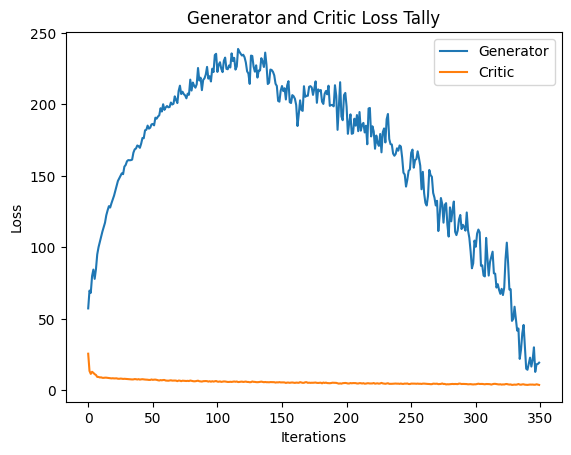

In [18]:
# Plot Generator and Discriminator Loss
plt.plot(G_losses, label = 'Generator')
plt.plot(C_losses, label = 'Critic')
plt.title('Generator and Critic Loss Tally')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

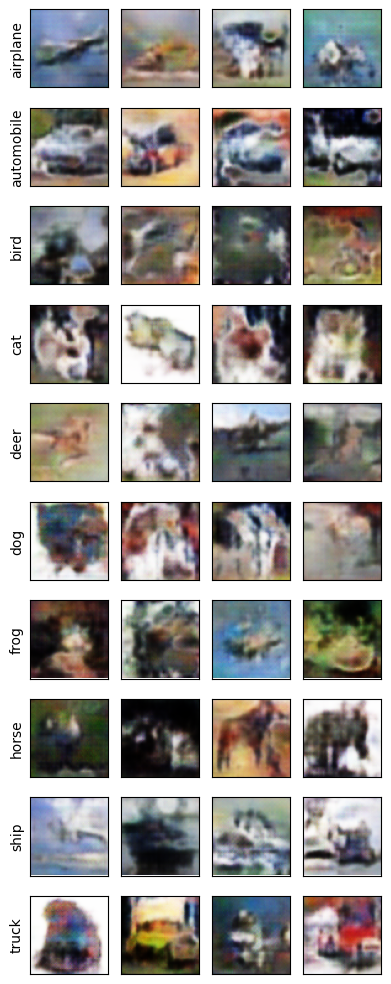

In [19]:
# Plot 4 Images of each label
fig, axs = plt.subplots(10,4, figsize = (4,10))
for i in range(10):
    for j in range(4):
        test_noise = torch.randn(batch_size,100,1,1)
        temp_holder = torch.ones(batch_size)
        test_labels = i*temp_holder.to(torch.int64)
        test_fake_image = generator(test_noise,test_labels)
        test_fake_image = inverse_transform(test_fake_image).cpu()
        axs[i][j].imshow(test_fake_image.permute(2,3,1,0).detach().numpy()[:,:,:,0])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
    axs[i][0].set_ylabel(train_data.classes[i])
        
plt.tight_layout()
plt.show()